### Unit 7: MANOVA and Linear Regression - Relationships and Application

Kyle P. Rasku MS BSN RN

In this notebook we'll dive into the details of MANOVA and Linear Regression in a healthcare context.

In [1]:
%matplotlib inline
import matplotlib.pylab
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(12,10))
import pandas as pd
import numpy as np
import datetime
import math

### MANOVA

Multivariate Analysis of Variance, often abbreviated "MANOVA", is a statistical test that extends the capabilities of the Analysis of Variance ("ANOVA"), discussed last week.  MANOVA allows for the **simultaneous analysis of multiple continuous dependent variables**.

When we use ANOVA, we analyze the difference between different **group means** for a single dependent variable. However, there might be scenarios where we need to analyze multiple dependent variables. In such cases, MANOVA can be a valuable tool.

#### How MANOVA Works

1. Hypotheses Formulation: The null hypothesis states that the **population means of the dependent variables are equal across different groups**, while the alternative hypothesis suggests that **at least one dependent variable’s mean is different**.


2. Test Assumptions: MANOVA, like other statistical tests, makes several assumptions, including: normality, linearity, homogeneity of variance-covariance matrices and absence of multicollinearity.  Before proceeding with the test, we should validate these assumptions.


3. Analysis and Computation: Having verified the appropriateness of the test, and with the null and alternative hypotheses in place, we perform the MANOVA test. Just as with ANOVA, when MANOVA is significant, it must be followed by determining **which pairs of means of dependent variables are significantly different**. This can be done using a variety of tests such as pairwise t-tests or Tukey’s test.  In our example, if MANOVA is significant, we'll perform this test.


4. Interpretation of Results: The results of a MANOVA will include:
   - F values
   - p-values, and 
   - degrees of freedom **for each dependent variable and for the model as a whole**. 
   
   These help us determine whether or not to reject your null hypothesis.


##### A pretend experiment

Let's pretend some Psychiatrists conducted an experiment.

They wanted to test a new medication for anxiety vs. standard treatment vs. a control group, and compare anxiety and self esteem levels for each group following the experiment, to see if any one of the treatments was superior, or at least not inferior to standard treatment.

For this, I'm using an N of 2135, and assuming that anxiety levels were measured using the GAD-7 and self esteem scores were measured using the Rosenberg scale.

In [2]:
self_esteem_scores = np.abs(np.random.normal(loc=15,scale=21.3,size=2135)).round(0)
anxiety_levels = np.abs(np.random.normal(loc=11,scale=6.23,size=2135)).round(0)

In [3]:
psych_experiment = pd.DataFrame(columns=['treatment_group', 'anxiety_level', 'self_esteem_score'])

treatment_group = {0: 'control', 1: 'treatment 1', 2: 'treatment 2'}
psych_experiment['self_esteem_score'] = self_esteem_scores
psych_experiment['anxiety_level'] = anxiety_levels
for i in range(2135):
    psych_experiment.at[i, 'treatment_group'] = treatment_group[np.random.randint(0,3)]

    
psych_experiment.head(10)

,treatment_group,anxiety_level,self_esteem_score
0,control,7.0,24.0
1,treatment 1,22.0,19.0
2,treatment 2,8.0,49.0
3,treatment 2,4.0,22.0
4,control,12.0,2.0
5,treatment 1,7.0,38.0
6,control,9.0,5.0
7,control,13.0,2.0
8,control,17.0,44.0
9,treatment 2,12.0,26.0


In [4]:
psych_experiment['anxiety_level'] = psych_experiment['anxiety_level'].astype('int64')
psych_experiment['self_esteem_score'] = psych_experiment['self_esteem_score'].astype('int64')
psych_experiment['treatment_group'] = pd.Categorical(psych_experiment['treatment_group'])

psych_experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135 entries, 0 to 2134
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   treatment_group    2135 non-null   category
 1   anxiety_level      2135 non-null   int64   
 2   self_esteem_score  2135 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 35.7 KB


In [5]:
psych_experiment.groupby('treatment_group').describe()

anxiety_level                                             \
                        count       mean       std  min  25%   50%   75%   
treatment_group                                                            
control                 753.0  11.081009  5.842350  0.0  7.0  11.0  15.0   
treatment 1             709.0  11.306065  5.879509  0.0  7.0  11.0  15.0   
treatment 2             673.0  11.083210  6.016018  0.0  7.0  11.0  15.0   

                      self_esteem_score                                        \
                  max             count       mean        std  min  25%   50%   
treatment_group                                                                 
control          30.0             753.0  20.803453  15.183142  0.0  9.0  18.0   
treatment 1      30.0             709.0  21.026798  15.427271  0.0  9.0  18.0   
treatment 2      38.0             673.0  20.846954  14.824230  0.0  9.0  19.0   

                             
                  75%   max  
treatment_group              
control          30.0  82.0  
treatment 1      30.0  84.0  
treatment 2      29.0  71.0

**STEP 1: Hypotheses Formulation:**

H(0): The means of the dependent variables (anxiety level and self esteem as measured by the GAD-7 and Rosenberg scale) are equal across the three treatment groups.

H(A): At least one of the dependent variables' means is different across the three treatment groups.

**STEP 2: Test Assumptions:**

normality, linearity, homogeneity of variance-covariance matrices and absence of multicollinearity

array([<Axes: title={'center': 'self_esteem_score'}>], dtype=object)

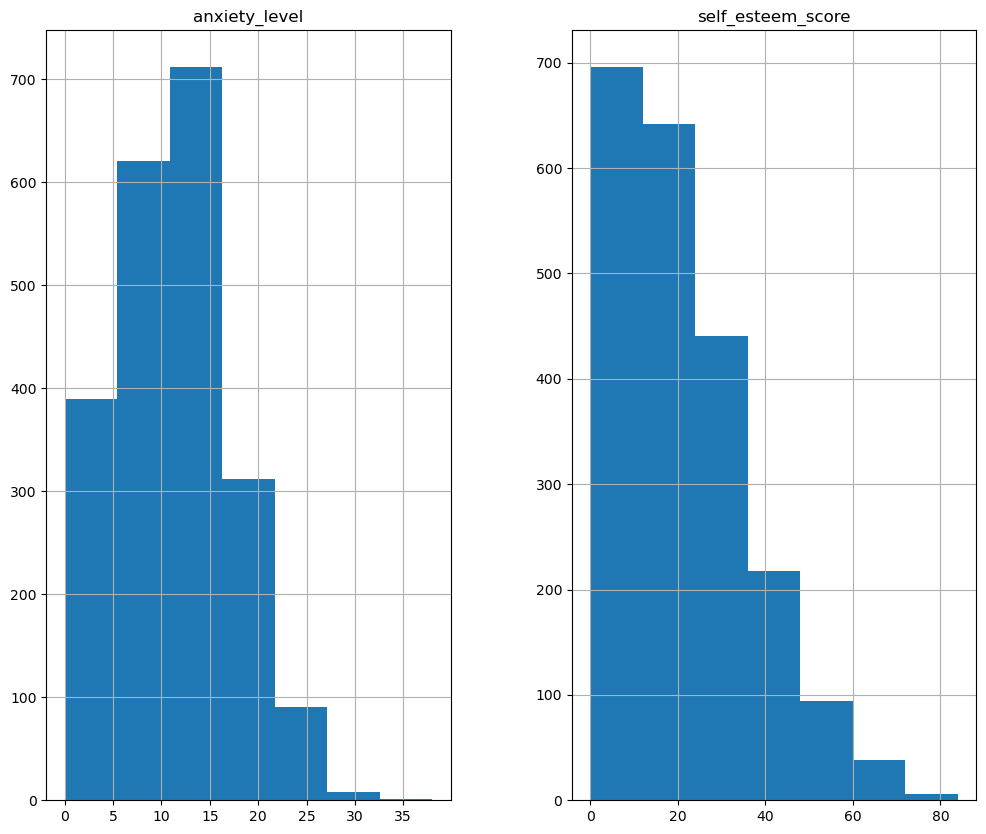

In [6]:
fig, axes = plt.subplots(1, 2)

psych_experiment.hist('anxiety_level', bins=7, ax=axes[0])
psych_experiment.hist('self_esteem_score', bins=7, ax=axes[1])

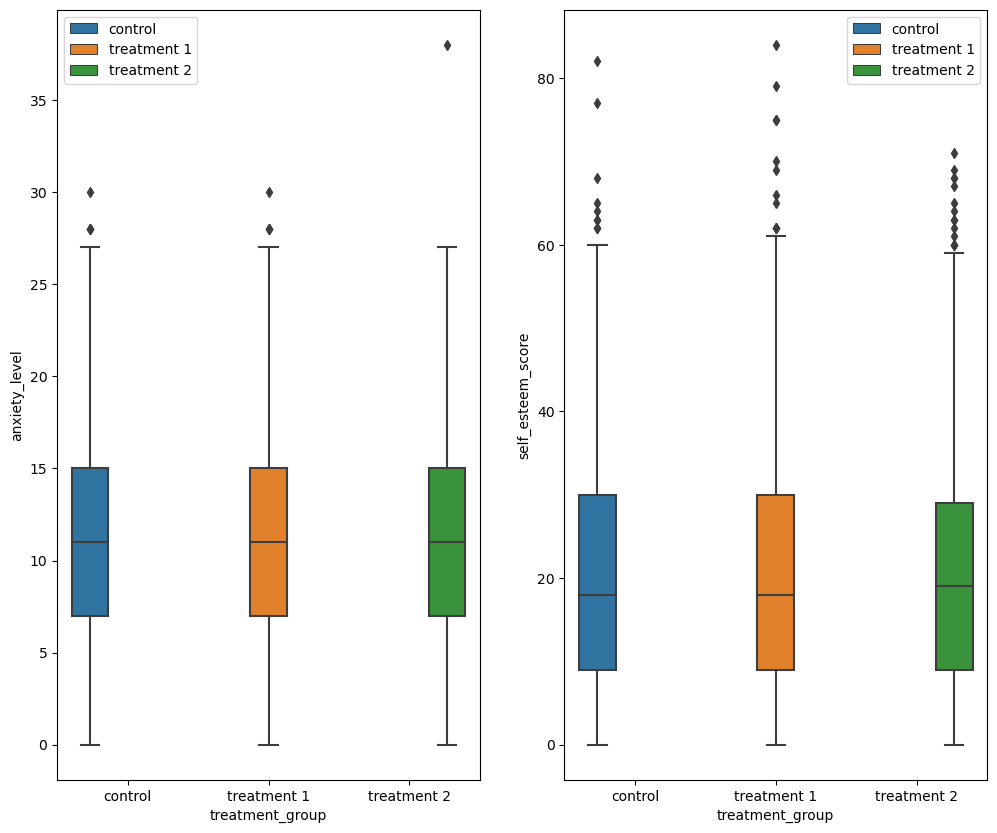

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=2)
sns.boxplot(data=psych_experiment, x="treatment_group", y="anxiety_level", hue=psych_experiment.treatment_group.tolist(), ax=axs[0])
sns.boxplot(data=psych_experiment, x="treatment_group", y="self_esteem_score", hue=psych_experiment.treatment_group.tolist(), ax=axs[1])
plt.show()

The test assumptions are more or less met by the distribution of the data.

Let's proceed with the test!

In [8]:
from statsmodels.multivariate.manova import MANOVA

fit = MANOVA.from_formula('anxiety_level + self_esteem_score ~ treatment_group', data=psych_experiment)
print(fit.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.3378 2.0000 2131.0000 2088.8201 0.0000
         Pillai's trace 0.6622 2.0000 2131.0000 2088.8201 0.0000
 Hotelling-Lawley trace 1.9604 2.0000 2131.0000 2088.8201 0.0000
    Roy's greatest root 1.9604 2.0000 2131.0000 2088.8201 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
      treatment_group     Value  Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------
            Wilks' lambda 0.9996 4.0000 4262.0000  0.1955 0.9408
           Pillai's trace 0.0004 4.0000 4264.

In this case, Pillai's trace is not statistically significant at p-value = 0.9408.

This shows that none of the means are significantly different for the two outcome variables and therefore, neither treatment 1 nor treatment 2 showed superiority over the control.

If the p-value had been significant, we would have next performed Tukey's test to see the degree of separation.

## Linear Regression

Linear regression is probably one of the most important and widely used regression techniques. One of its main advantages is the ease of interpreting results, however - it is important to remember that the relationships between the variables are correlations, and not causal!  It is also important to remember that the coefficients are only as good as the R-Squared - in other words, the extent of correlation to the outcome is only as accurate as the model as a whole is useful.  If the model has a high R-Squared and good predictive power, this makes it more likely that coefficient values of the independent variables tell you something worthwhile about the relationship of that variable to the outcome.

**Problem Formulation**

When implementing linear regression of some dependent variable 𝑦 on the set of independent variables 𝐱 = (𝑥₁, …, 𝑥ᵣ), where 𝑟 is the number of predictors, you assume a linear relationship between 𝑦 and 𝐱: 𝑦 = 𝛽₀ + 𝛽₁𝑥₁ + ⋯ + 𝛽ᵣ𝑥ᵣ + 𝜀. This equation is the regression equation. 𝛽₀, 𝛽₁, …, 𝛽ᵣ are the regression coefficients, and 𝜀 is the random error.

Linear regression calculates the estimators of the regression coefficients or simply the predicted weights, denoted with 𝑏₀, 𝑏₁, …, 𝑏ᵣ. These estimators define the estimated regression function 𝑓(𝐱) = 𝑏₀ + 𝑏₁𝑥₁ + ⋯ + 𝑏ᵣ𝑥ᵣ. This function should capture the dependencies between the inputs and output sufficiently well.

The estimated or predicted response, 𝑓(𝐱ᵢ), for each observation 𝑖 = 1, …, 𝑛, should be as close as possible to the corresponding actual response 𝑦ᵢ. The differences 𝑦ᵢ - 𝑓(𝐱ᵢ) for all observations 𝑖 = 1, …, 𝑛, are called the residuals. Regression is about determining the best predicted weights—that is, the weights corresponding to the smallest residuals.

To get the best weights, you usually minimize the sum of squared residuals (SSR) for all observations 𝑖 = 1, …, 𝑛: SSR = Σᵢ(𝑦ᵢ - 𝑓(𝐱ᵢ))². This approach is called the method of ordinary least squares.

In [9]:
!pip install ucimlrepo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [24]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart = pd.read_csv("https://archive.ics.uci.edu/static/public/45/data.csv")
heart_backup = heart.copy()
heart.dropna(inplace=True)
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [27]:
X = heart[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']].copy()
y = heart[['num']].copy()

In [28]:
import statsmodels.api as sm

mod = sm.OLS(y, X)

res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    num   R-squared (uncentered):                   0.728
Model:                            OLS   Adj. R-squared (uncentered):              0.715
Method:                 Least Squares   F-statistic:                              58.36
Date:                Wed, 08 May 2024   Prob (F-statistic):                    2.97e-72
Time:                        00:22:53   Log-Likelihood:                         -359.17
No. Observations:                 297   AIC:                                      744.3
Df Residuals:                     284   BIC:                                      792.4
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0112      0.006     -1.979      0.049      -0.022   -6.25e-05
sex            0.1576      0.114      1.378      0.169      -0.067       0.383
cp             0.1770      0.054      3.302      0.001       0.072       0.283
trestbps       0.0035      0.003      1.230      0.220      -0.002       0.009
chol        5.487e-05      0.001      0.056      0.955      -0.002       0.002
fbs           -0.0707      0.141     -0.500      0.617      -0.349       0.208
restecg        0.1040      0.050      2.065      0.040       0.005       0.203
thalach       -0.0074      0.002     -4.003      0.000      -0.011      -0.004
exang          0.2215      0.120      1.843      0.066      -0.015       0.458
oldpeak        0.1870      0.054      3.434      0.001       0.080       0.294
slope          0.1347      0.096      1.404      0.161      -0.054       0.323
ca             0.4376      0.059      7.356      0.000       0.321       0.555
thal           0.1404      0.031      4.579      0.000       0.080       0.201
==============================================================================
Omnibus:                       19.497   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.289
Skew:                           0.524   Prob(JB):                     5.32e-06
Kurtosis:                       3.929   Cond. No.                         961.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpreting the Results

The R-Squared value of 0.716 indicates that the variables explain 72.8% (about 73%) of the variation in the outcome, 'num', which is a number indicating the degree of heart disease in a patient, between 0 (no disease) and 4 (most severe disease).

'ca', 'exang', 'oldpeak', 'slope', 'cp' and 'sex' contributed the most value to the model's predictive ability.  

These variables had the highest coefficient values and signficant p-values.

'ca' was the most significant variable, which is not surprising because it is fairly synonymous with the definition of heart disease: "number of major vessels (0-3) colored by flourosopy"

'exang': exercise induced angina

'oldpeak': ST depression induced by exercise relative to rest

'slope': the slope of the peak exercise ST segment

'cp': chest pain type

'sex': male v. female


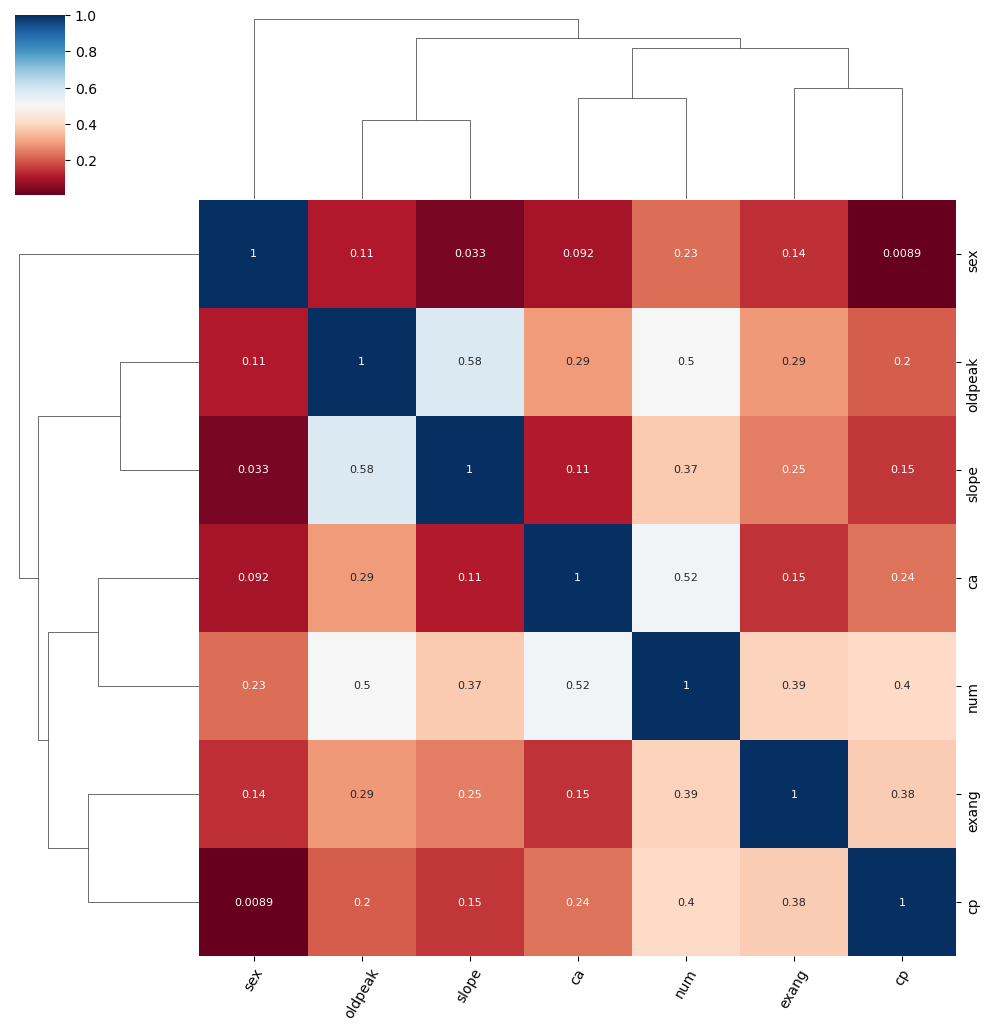

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(heart[['ca', 'exang', 'oldpeak', 'slope', 'cp', 'sex', 'num']].corr(), 
                   method = 'complete', 
                   cmap   = 'RdBu', 
                   annot  = True, 
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);

The Seaborn library's 'clustermap' function uses hierarchical clustering to arrange relevant features together and produce the tree-like dendrograms.

There are three notable clusters in this plot: cp & exang, num & ca (arguably multicollinear with and the most predictive of num, so that makes sense!), and slope & oldpeak; the fourth cluster isn't really a cluster - it just shows the influence of sex is independent of the other measures.